## Check data

In [1]:
from pathlib import Path
import os

path_str = '/home/df630/SyntheticJets/data/TTBar_val___1Mfromeach_403030.h5'
path_obj = Path(path_str)

root_dir = path_obj.parts[0]

print(f"The root directory of '{path_str}' is: {root_dir}")

path_str_win = "C:\\Users\\user\\documents\\file.txt"
path_obj_win = Path(path_str_win)

root_dir_win = path_obj_win.parts[0]

print(f"The root directory of '{path_str_win}' is: {root_dir_win}")

current_dir = Path(os.getcwd())
root_current_dir = current_dir.parts[0]

print(f"The root directory of the current working directory is: {root_current_dir}")

The root directory of '/home/df630/SyntheticJets/data/TTBar_val___1Mfromeach_403030.h5' is: /
The root directory of 'C:\Users\user\documents\file.txt' is: C:\Users\user\documents\file.txt
The root directory of the current working directory is: /


In [1]:
from datamodule_jetclass import JetSequence
import numpy as np

num_bins = np.prod([41,31,31])  # e.g. 41*31*31

tops = JetSequence(filepath='/home/df630/SyntheticJets/data/TTBar_val___1Mfromeach_403030.h5',    
                   start_token=num_bins,
                   end_token=num_bins+1,
                   pad_token=num_bins+2, 
                    )
qcd = JetSequence(filepath='/home/df630/SyntheticJets/data/ZJetsToNuNu_val___1Mfromeach_403030.h5',                    
                   start_token=num_bins,
                   end_token=num_bins+1,
                   pad_token=num_bins+2, )

tops_seq = tops.map_to_sequence()
tops_bin = tops.seq_to_bins_decoding(tops_seq)
qcd_seq = qcd.map_to_sequence()
qcd_bin = qcd.seq_to_bins_decoding(qcd_seq)


In [14]:
tops_tokens = tops_seq.ravel()          # flatten to 1-D


NameError: name 'tops_seq' is not defined

In [10]:
tops_gen_seq

tensor([[28317, 27356, 27358,  ...,    -1,    -1,    -1],
        [27543, 26330, 25369,  ...,    -1,    -1,    -1],
        [25591, 25591, 22492,  ...,    -1,    -1,    -1],
        ...,
        [25371, 23665, 23486,  ...,    -1,    -1,    -1],
        [26520, 26361, 23508,  ...,    -1,    -1,    -1],
        [31266, 27352, 27352,  ...,    -1,    -1,    -1]])

In [9]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ------------------------------------------------------------
# 1.  Build a flat list/array of tokens from your full dataset
# ------------------------------------------------------------
# Your jets might be in an (N_jets, N_max) int array called `seqs`.
tops_tokens = tops_seq.ravel()          # flatten to 1-D
tops_tokens = tops_tokens[tops_tokens < num_bins]   # drop any padding tokens, if you used −1 for pad
qcd_tokens = qcd_seq.ravel()          # flatten to 1-D
qcd_tokens = qcd_tokens[qcd_tokens < num_bins]   # drop any padding tokens, if you used −1 for pad

# ------------------------------------------------------------
# 2.  Count token frequencies
# ------------------------------------------------------------
tops_freq = Counter(tops_tokens)         # {token_id: count}
tops_counts = np.array(sorted(tops_freq.values(), reverse=True))
tops_ranks  = np.arange(1, len(tops_counts)+1)

qcd_freq = Counter(qcd_tokens)         # {token_id: count}
qcd_counts = np.array(sorted(qcd_freq.values(), reverse=True))
qcd_ranks  = np.arange(1, len(qcd_counts)+1)


# ------------------------------------------------------------
# 3.  Log–log plot
# ------------------------------------------------------------
plt.figure(figsize=(5,4))
plt.loglog(tops_ranks, tops_counts/tops_counts.sum(), '.', label='tops JetClass')
plt.loglog(qcd_ranks, qcd_counts/qcd_counts.sum(), '.', label='QCD JetClass')
plt.xlabel('rank $r$')
plt.ylabel('empirical probability $P(r)$')
plt.title('Zipf laws')
plt.tight_layout()
plt.legend()
plt.show()

# # ------------------------------------------------------------
# # 4.  Optional: fit a power law to the head (say first 2 orders of magnitude)
# # ------------------------------------------------------------
# head = counts[:2*10**2]             # heuristic “head” cut
# slope, intercept, *_ = linregress(np.log(ranks[:len(head)]), np.log(head))
# alpha = -slope
# print(f"Estimated Zipf exponent α ≃ {alpha:.2f}")


IndexError: too many indices for tensor of dimension 1

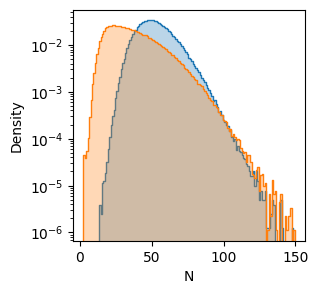

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, _ = plt.subplots(1, 1, figsize=(3, 3))
sns.histplot((tops_seq != tops.pad_token).sum(axis=1), discrete=True, fill=True, alpha=0.3, label='gpt2', element='step', stat='density',)
sns.histplot((qcd_seq != qcd.pad_token).sum(axis=1), discrete=True, fill=True, alpha=0.3, label='gpt2', element='step', stat='density',)

plt.xlabel('N')
plt.ylabel('Density')
plt.yscale('log')
plt.show()

## validation plots

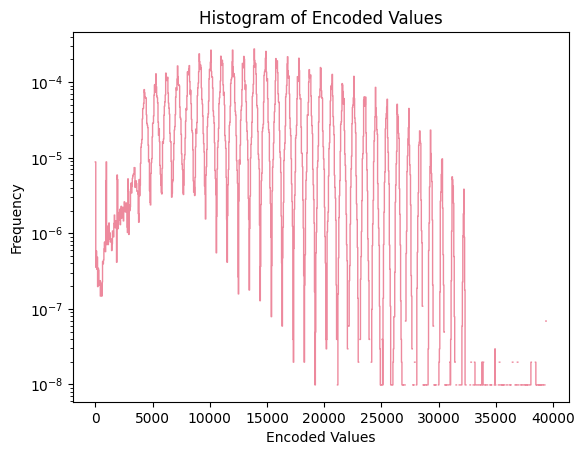

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(tops_gen_seq[tops_gen_seq>=0], lw=1,bins=1000, fill=False, alpha=0.5, label='sample', element='step', stat='density', color='crimson', log_scale=(False, True))
plt.xlabel('Encoded Values')
plt.ylabel('Frequency')
plt.title('Histogram of Encoded Values')
plt.show()

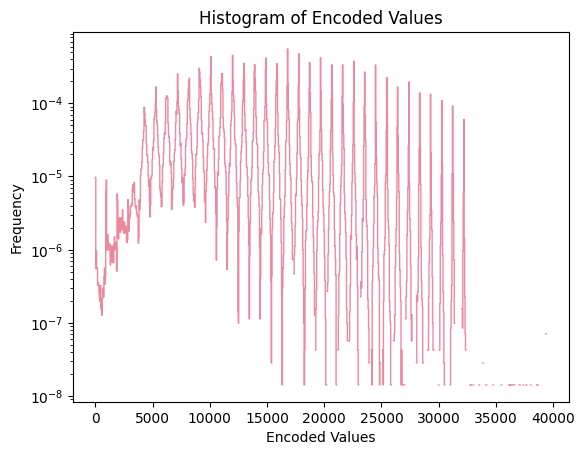

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(qcd_gen_seq[qcd_gen_seq>0], lw=1,bins=1000, fill=False, alpha=0.5, label='sample', element='step', stat='density', color='crimson', log_scale=(False, True))
plt.xlabel('Encoded Values')
plt.ylabel('Frequency')
plt.title('Histogram of Encoded Values')
plt.show()

## Binned jets

In [1]:
import h5py

def load_h5_data(filepath, key, num_jets=None):
    with h5py.File(filepath, "r") as f:
        arr = f[f'{key}/block0_values']
        raw = arr[:] if num_jets is None else arr[: num_jets]
    N, _ = raw.shape[0], raw.shape[1]
    return raw.reshape(N, -1, 3)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as L

from torch.utils.data import DataLoader
from models import JetGPT2Model
from datamodule_jetclass import JetSequence

from utils import make_continuous, binnify

###############################################################################
N = 100_000  # num gen jets
sig_id = "dd361953432549e096e295bcb7523f7e"        # comet run folder
bkg_id = "10eed87576d64e9e9bbb6f4a5322978d"
path = "/home/df630/SyntheticJets/experiments/results/comet/tokenized-jets/"
num_bins = np.prod([41,31,31])  # e.g. 41*31*31



###############################################################################


#...Aachen Gen

tops_aachen = JetSequence(filepath='/home/df630/SyntheticJets/data/tops_aachen_discretize_samples1000000_trunc_5000.h5', )
qcd_aachen = JetSequence(filepath='/home/df630/SyntheticJets/data/qcd_aachen_discretize_samples1000000_trunc_5000.h5', )
# tops_aachen_seq = tops_aachen.map_to_sequence()
# qcd_aachen_seq = qcd_aachen.map_to_sequence()

# tops_aachen_bins = make_continuous(torch.tensor(tops_aachen.data[:N]).long(), bin_dir='data')
# qcd_aachen_bins = make_continuous(torch.tensor(qcd_aachen.data[:N]).long(), bin_dir='data')

#...Test

tops = JetSequence(filepath='/home/df630/SyntheticJets/data/TTBar_test___1Mfromeach_403030.h5',
                   start_token=num_bins,
                   end_token=num_bins+1,
                   pad_token=num_bins+2)

qcd = JetSequence(filepath='/home/df630/SyntheticJets/data/ZJetsToNuNu_test___1Mfromeach_403030.h5',
                   start_token=num_bins,
                   end_token=num_bins+1,
                   pad_token=num_bins+2 )
                   
tops_test_seq = tops.map_to_sequence()[:N]
qcd_test_seq = qcd.map_to_sequence()[:N]

tops_test_bins = binnify(torch.tensor(tops.data[:N]).long())
qcd_test_bins = binnify(torch.tensor(qcd.data[:N]).long())

# tops_test_bins = load_h5_data('/home/df630/SyntheticJets/data/TTBar_test___1Mfromeach_403030.h5','raw', num_jets=N)
# qcd_test_bins = load_h5_data('/home/df630/SyntheticJets/data/ZJetsToNuNu_test___1Mfromeach_403030.h5','raw', num_jets=N)
# tops_test_bins = torch.tensor(tops_test_bins)
# qcd_test_bins = torch.tensor(qcd_test_bins)


#...Gen

tops_gen_seq = torch.tensor(np.load(f'{path}{sig_id}/gen_results_best/gen_TTBar_seq_best_tokens.npy'))[:N]
qcd_gen_seq = torch.tensor(np.load(f'{path}{bkg_id}/gen_results_best/gen_ZJetsToNuNu_seq_best_tokens.npy'))[:N]
tops_gen_bins = tops.data(tops.seq_to_bins_decoding(tops_gen_seq), bin_dir='data')
qcd_gen_bins = tops.data(qcd.seq_to_bins_decoding(qcd_gen_seq), bin_dir='data')

# save to npy

# np.save(f'{path}{sig_id}/gen_tops_bins_gpt2_top5000_jets1e6.npy', tops_gen_bins)
# np.save(f'{path}{bkg_id}/gen_qcd_bins_gpt2_top5000_jets1e6.npy', qcd_gen_bins)

In [12]:
from utils import make_continuous, binnify
tops_gen_bins = binnify(torch.tensor(tops.seq_to_bins_decoding(tops_gen_seq)),'data')
qcd_gen_bins = binnify(torch.tensor(qcd.seq_to_bins_decoding(qcd_gen_seq)),'data')

tops_test_bins = binnify(torch.tensor(tops.data[:N]).long(), 'data')
qcd_test_bins = binnify(torch.tensor(qcd.data[:N]).long(), 'data')

40 30 30


IndexError: index 41 is out of bounds for axis 0 with size 40

In [4]:
tops_test_seq.shape

(100000, 202)

In [206]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ------------------------------------------------------------
# 1.  Build a flat list/array of tokens from your full dataset
# ------------------------------------------------------------
# Your jets might be in an (N_jets, N_max) int array called `seqs`.

tops_test_tokens = tops_test_seq.ravel()          # flatten to 1-D
tops_test_tokens = tops_test_tokens[tops_test_tokens < num_bins]   # drop any padding tokens, if you used −1 for pad

qcd_test_tokens = qcd_test_seq.ravel()          # flatten to 1-D
qcd_test_tokens = qcd_test_tokens[qcd_test_tokens < num_bins]   # drop any padding tokens, if you used −1 for pad

tops_gen_tokens = tops_gen_seq.ravel()          # flatten to 1-D
tops_gen_tokens = tops_gen_tokens[tops_gen_tokens >= 0]   # drop any padding tokens, if you used −1 for pad

qcd_gen_tokens = qcd_gen_seq.ravel()          # flatten to 1-D
qcd_gen_tokens = qcd_gen_tokens[qcd_gen_tokens >= 0]   # drop any padding tokens, if you used −1 for pad


# # ------------------------------------------------------------
# # 2.  Count token frequencies
# # ------------------------------------------------------------
tops_test_freq = Counter(tops_test_tokens)         # {token_id: count}
tops_test_counts = np.array(sorted(tops_test_freq.values(), reverse=True))
tops_test_ranks  = np.arange(1, len(tops_test_counts)+1)

qcd_test_freq = Counter(qcd_test_tokens)         # {token_id: count}
qcd_test_counts = np.array(sorted(qcd_test_freq.values(), reverse=True))
qcd_test_ranks  = np.arange(1, len(qcd_test_counts)+1)

tops_gen_freq = Counter(tops_gen_tokens)         # {token_id: count}
tops_gen_counts = np.array(sorted(tops_gen_freq.values(), reverse=True))
tops_gen_ranks  = np.arange(1, len(tops_gen_counts)+1)

qcd_gen_freq = Counter(qcd_gen_tokens)         # {token_id: count}
qcd_gen_counts = np.array(sorted(qcd_gen_freq.values(), reverse=True))
qcd_gen_ranks  = np.arange(1, len(qcd_gen_counts)+1)


# # ------------------------------------------------------------
# # 3.  Log–log plot
# # ------------------------------------------------------------
# plt.figure(figsize=(5,4))
# plt.loglog(tops_test_ranks, tops_test_counts/tops_test_counts.sum(), '.', label='tops JetClass', marker='.', color='Tab:blue', alpha=0.5)
# plt.loglog(qcd_test_ranks, qcd_test_counts/qcd_test_counts.sum(), '.', label='QCD JetClass', marker='.', color='Tab:orange', alpha=0.5)
# plt.loglog(tops_gen_ranks, tops_gen_counts/tops_gen_counts.sum(), '.', label='tops GPT-2', marker='v', color='Tab:blue', alpha=0.5)
# plt.loglog(qcd_gen_ranks, qcd_gen_counts/qcd_gen_counts.sum(), '.', label='QCD GPT-2', marker='v', color='Tab:orange', alpha=0.5)
# plt.xlabel('rank $r$')
# plt.ylabel('empirical probability $P(r)$')
# plt.title('Zipf laws')
# plt.tight_layout()
# plt.legend()
# plt.show()



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f9b7802cb20>>
Traceback (most recent call last):
  File "/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/ipykernel-7.0.0a0-py3.10.egg/ipykernel/ipkernel.py", line 757, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
  File "/home/df630/.conda/envs/markov_bridges/lib/python3.10/site-packages/ipykernel-7.0.0a0-py3.10.egg/ipykernel/kernelapp.py", line 554, in sigint_handler
    raise KeyboardInterrupt
KeyboardInterrupt: 


In [2]:
from matplotlib.gridspec import GridSpec
import seaborn as sns

def plot_kin_with_ratio(test, gen, aachen, path='results_plot.png', jet='jetclass'):

    test = test.cpu().numpy()
    gen = gen.cpu().numpy()
    aachen = aachen.cpu().numpy()

    bins = [np.arange(-1, 7, 0.05), 
            np.arange(-1, 1, 0.01), 
            np.arange(-1, 1, 0.01), 
            np.arange(0, 128, 2)]

    ylims = (0.4, 4.5, 4.5, 0.035)

    fig = plt.figure(figsize=(12, 2.5))
    gs = GridSpec(2, 4, height_ratios=(3,1), hspace=0.1, wspace=0.3)

    # --- TOP ROW: Hard‑coded histplots ---
    
    ax0 = fig.add_subplot(gs[0,0])
    sns.histplot(np.log(test[test[...,0]>0][...,0]),bins=bins[0],lw=0.4,fill=True,  color='k', alpha=0.2,  label=jet, element='step', stat='density', ax=ax0)
    sns.histplot(np.log(gen[gen[...,0]>0][...,0]), bins=bins[0], lw=0.8, fill=False, color='crimson', label='GPT2 Rutgers',element='step', stat='density', ax=ax0)
#     sns.histplot(np.log(aachen[aachen[...,0]>0][...,0]), bins=bins[0], lw=0.8, fill=False, label='GPT2 Aachen',element='step', stat='density', ax=ax0)
    ax0.set_ylabel('density', fontsize=12)
    ax0.legend(fontsize=6)
    ax0.set_ylim(0, ylims[0])

    ax1 = fig.add_subplot(gs[0,1])
    sns.histplot(test[test[...,0]>0][...,1], bins=bins[1], lw=0.4, fill=True,  color='k', alpha=0.2,  element='step', stat='density', ax=ax1)
    sns.histplot(gen[gen[...,0]>0][...,1],  bins=bins[1], lw=0.8, fill=False, color='crimson', element='step', stat='density', ax=ax1)
#     sns.histplot(aachen[aachen[...,0]>0][...,1], bins=bins[1], lw=0.8, fill=False, element='step', stat='density', ax=ax1)
    ax1.set_ylabel(' ', fontsize=12)
    ax1.set_ylim(0, ylims[1])

    ax2 = fig.add_subplot(gs[0,2])
    sns.histplot(test[test[...,0]>0][...,2], bins=bins[2], lw=0.4, fill=True,  color='k',  alpha=0.2, element='step', stat='density', ax=ax2)
    sns.histplot(gen[gen[...,0]>0][...,2],  bins=bins[2], lw=0.8, fill=False, color='crimson', element='step', stat='density', ax=ax2)
#     sns.histplot(aachen[aachen[...,0]>0][...,2], bins=bins[2], lw=0.8, fill=False,element='step', stat='density', ax=ax2)
    ax2.set_ylabel(' ', fontsize=12)
    ax2.set_ylim(0, ylims[2])

    ax3 = fig.add_subplot(gs[0,3])
    sns.histplot((test[...,0] > 0).sum(axis=1),  bins=bins[3], lw=0.4, fill=True,  color='k', alpha=0.2,element='step', stat='density', ax=ax3)
    sns.histplot((gen[...,0] > 0).sum(axis=1),  bins=bins[3], lw=0.8, fill=False, color='crimson', element='step', stat='density', ax=ax3)
#     sns.histplot((aachen[...,0] > 0).sum(axis=1),  bins=bins[3], lw=0.8, fill=False, label='aachen',element='step', stat='density', ax=ax3)
    ax3.set_ylabel(' ', fontsize=12)
    ax3.set_ylim(0, ylims[3])

    # --- BOTTOM ROW: Ratio panels ---

    h0_t, e0 = np.histogram(np.log(test[test[...,0]>0][...,0]), bins=bins[0],      density=True)
    h0_g, _  = np.histogram(np.log(gen[gen[...,0]>0][...,0]),  bins=e0,         density=True)
#     h0_a, _  = np.histogram(np.log(aachen[aachen[...,0]>0][...,0]), bins=e0,       density=True)
    centers0 = 0.5*(e0[:-1] + e0[1:])
    ax0r = fig.add_subplot(gs[1,0], sharex=ax0)
    ax0r.step(centers0, h0_g/(h0_t+1e-8), where='mid', color='crimson', lw=1)
#     ax0r.step(centers0, h0_a/(h0_t+1e-8), where='mid',  lw=1)
    ax0r.set_ylim(0.7,1.3)
    ax0r.set_xlabel(r'$\log(p_T)$')
    ax0r.set_ylabel('ratio', fontsize=8)
    ax0r.axhline(y=1, color='k', linestyle='--', lw=0.75)

    h1_t, e1 = np.histogram(test[test[...,0]>0][...,1], bins=bins[1], density=True)
    h1_g, _  = np.histogram(gen[gen[...,0]>0][...,1],  bins=e1, density=True)
#     h1_a, _  = np.histogram(aachen[aachen[...,0]>0][...,1], bins=e1, density=True)
    centers1 = 0.5*(e1[:-1] + e1[1:])
    ax1r = fig.add_subplot(gs[1,1], sharex=ax1)
    ax1r.step(centers1, h1_g/(h1_t+1e-8), where='mid',color='crimson',lw=1)
#     ax1r.step(centers1, h1_a/(h1_t+1e-8), where='mid',   lw=1)
    ax1r.axhline(y=1, color='k', linestyle='--', lw=0.75)
    ax1r.set_ylim(0.7,1.3)
    ax1r.set_xlabel(r'$\Delta\eta$')

    h2_t, e2 = np.histogram(test[test[...,0]>0][...,2], bins=bins[2],      density=True)
    h2_g, _  = np.histogram(gen[gen[...,0]>0][...,2],  bins=e2,         density=True)
#     h2_a, _  = np.histogram(aachen[aachen[...,0]>0][...,2], bins=e2,       density=True)
    centers2 = 0.5*(e2[:-1] + e2[1:])
    ax2r = fig.add_subplot(gs[1,2], sharex=ax2)
    ax2r.step(centers2, h2_g/(h2_t+1e-8), where='mid', color='crimson',lw=1)
#     ax2r.step(centers2, h2_a/(h2_t+1e-8), where='mid',  lw=1)
    ax2r.axhline(y=1, color='k', linestyle='--', lw=0.75)
    ax2r.set_ylim(0.7,1.3)
    ax2r.set_xlabel(r'$\Delta\phi$')

    h3_t, e3 = np.histogram((test[...,0] > 0).sum(axis=1), bins=bins[3], density=True)
    h3_g, _  = np.histogram((gen[...,0] > 0).sum(axis=1),  bins=e3,  density=True)
#     h3_a, _  = np.histogram((aachen[...,0] > 0).sum(axis=1), bins=e3,density=True)
    centers3 = 0.5*(e3[:-1] + e3[1:])
    ax3r = fig.add_subplot(gs[1,3], sharex=ax3)
    ax3r.step(centers3, h3_g/(h3_t+1e-8), where='mid',color='crimson',lw=1)
#     ax3r.step(centers3, h3_a/(h3_t+1e-8), where='mid',   lw=1)
    ax3r.axhline(y=1, color='k', linestyle='--', lw=0.75)
    ax3r.set_ylim(0.7,1.3)
    ax3r.set_xlabel(r'$N$')

    plt.tight_layout()
    plt.savefig(path, dpi=350)



def plot_hl_with_ratio(test, gen, aachen, path='results_plot.png', jet='jetclass'):

    gen_HL = jets_HighLevelFeats(gen)
#     aachen_HL = jets_HighLevelFeats(aachen)
    test_HL = jets_HighLevelFeats(test)

    gen_substructure = JetSubstructure(gen)
#     aachen_substructure = JetSubstructure(aachen)
    test_substructure = JetSubstructure(test)

    bins = [np.arange(400, 1200, 16), 
            np.arange(0., 500, 10), 
            np.arange(0, 1, 0.025), 
            np.arange(0, 1, 0.025)]

    ylims = ( 0.008 , 0.025, 5, 6)

    fig = plt.figure(figsize=(12, 2.5))
    gs = GridSpec(2, 4, height_ratios=(3,1), hspace=0.1, wspace=0.3)

    # --- TOP ROW: Hard‑coded histplots ---
    
    ax0 = fig.add_subplot(gs[0,0])
    sns.histplot(test_HL[...,0],bins=bins[0],lw=0.4,fill=True,  color='k', alpha=0.2,  label=jet, element='step', stat='density', ax=ax0)
    sns.histplot(gen_HL[...,0], bins=bins[0], lw=0.8, fill=False, color='crimson', label='GPT2 Rutgers',element='step', stat='density', ax=ax0)
#     sns.histplot(aachen_HL[...,0], bins=bins[0], lw=0.8, fill=False, label='GPT2 Aachen',element='step', stat='density', ax=ax0)
    ax0.set_ylabel('density', fontsize=12)
    ax0.set_ylim(0, ylims[0])
    ax0.legend(fontsize=7)

    ax1 = fig.add_subplot(gs[0,1])
    sns.histplot(test_HL[...,3], bins=bins[1], lw=0.4, fill=True,  color='k', alpha=0.2,  element='step', stat='density', ax=ax1)
    sns.histplot(gen_HL[...,3],  bins=bins[1], lw=0.8, fill=False, color='crimson', element='step', stat='density', ax=ax1)
#     sns.histplot(aachen_HL[...,3], bins=bins[1], lw=0.8, fill=False, element='step', stat='density', ax=ax1)
    ax1.set_ylabel(' ', fontsize=12)
    ax1.set_ylim(0, ylims[1])

    ax2 = fig.add_subplot(gs[0,2])
    sns.histplot(test_substructure.tau21, bins=bins[2], lw=0.4, fill=True,  color='k',  alpha=0.2, element='step', stat='density', ax=ax2)
    sns.histplot(gen_substructure.tau21,  bins=bins[2], lw=0.8, fill=False, color='crimson', element='step', stat='density', ax=ax2)
#     sns.histplot(aachen_substructure.tau21, bins=bins[2], lw=0.8, fill=False,element='step', stat='density', ax=ax2)
    ax2.set_ylabel(' ', fontsize=12)
    ax2.set_ylim(0, ylims[2])

    ax3 = fig.add_subplot(gs[0,3])
    sns.histplot(test_substructure.tau32, bins=bins[3], lw=0.4, fill=True,  color='k', alpha=0.2,element='step', stat='density', ax=ax3)
    sns.histplot(gen_substructure.tau32,  bins=bins[3], lw=0.8, fill=False, color='crimson', element='step', stat='density', ax=ax3)
#     sns.histplot(aachen_substructure.tau32, bins=bins[3], lw=0.8, fill=False, label='aachen',element='step', stat='density', ax=ax3)
    ax3.set_ylabel(' ', fontsize=12)
    ax3.set_ylim(0, ylims[3])

    # --- BOTTOM ROW: Ratio panels ---

    h0_t, e0 = np.histogram(test_HL[...,0], bins=bins[0],      density=True)
    h0_g, _  = np.histogram(gen_HL[...,0],  bins=e0,         density=True)
#     h0_a, _  = np.histogram(aachen_HL[...,0], bins=e0,       density=True)
    centers0 = 0.5*(e0[:-1] + e0[1:])
    ax0r = fig.add_subplot(gs[1,0], sharex=ax0)
    ax0r.step(centers0, h0_g/(h0_t+1e-8), where='mid', color='crimson', lw=1)
#     ax0r.step(centers0, h0_a/(h0_t+1e-8), where='mid',  lw=1)
    ax0r.set_ylim(0.7,1.3)
    ax0r.set_xlabel(r'jet $p_T$')
    ax0r.set_ylabel('ratio', fontsize=8)
    ax0r.axhline(y=1, color='k', linestyle='--', lw=0.75)

    h1_t, e1 = np.histogram(test_HL[...,3], bins=bins[1], density=True)
    h1_g, _  = np.histogram(gen_HL[...,3],  bins=e1, density=True)
#     h1_a, _  = np.histogram(aachen_HL[...,3], bins=e1, density=True)
    centers1 = 0.5*(e1[:-1] + e1[1:])
    ax1r = fig.add_subplot(gs[1,1], sharex=ax1)
    ax1r.step(centers1, h1_g/(h1_t+1e-8), where='mid',color='crimson',lw=1)
#     ax1r.step(centers1, h1_a/(h1_t+1e-8), where='mid',   lw=1)
    ax1r.axhline(y=1, color='k', linestyle='--', lw=0.75)
    ax1r.set_ylim(0.7,1.3)
    ax1r.set_xlabel(r'jet mass')

    h2_t, e2 = np.histogram(test_substructure.tau21, bins=bins[2],      density=True)
    h2_g, _  = np.histogram(gen_substructure.tau21,  bins=e2,         density=True)
#     h2_a, _  = np.histogram(aachen_substructure.tau21, bins=e2,       density=True)
    centers2 = 0.5*(e2[:-1] + e2[1:])
    ax2r = fig.add_subplot(gs[1,2], sharex=ax2)
    ax2r.step(centers2, h2_g/(h2_t+1e-8), where='mid', color='crimson',lw=1)
#     ax2r.step(centers2, h2_a/(h2_t+1e-8), where='mid',  lw=1)
    ax2r.axhline(y=1, color='k', linestyle='--', lw=0.75)
    ax2r.set_ylim(0.7,1.3)
    ax2r.set_xlabel(r'$\tau_{21}$')

    h3_t, e3 = np.histogram(test_substructure.tau32, bins=bins[3],      density=True)
    h3_g, _  = np.histogram(gen_substructure.tau32,  bins=e3,         density=True)
#     h3_a, _  = np.histogram(aachen_substructure.tau32, bins=e3,       density=True)
    centers3 = 0.5*(e3[:-1] + e3[1:])
    ax3r = fig.add_subplot(gs[1,3], sharex=ax3)
    ax3r.step(centers3, h3_g/(h3_t+1e-8), where='mid',color='crimson',lw=1)
#     ax3r.step(centers3, h3_a/(h3_t+1e-8), where='mid',   lw=1)
    ax3r.axhline(y=1, color='k', linestyle='--', lw=0.75)
    ax3r.set_ylim(0.7,1.3)
    ax3r.set_xlabel(r'$\tau_{32}$')

    plt.tight_layout()
    plt.savefig(path, dpi=500, bbox_inches='tight')





In [3]:
plot_kin_with_ratio(tops_test_bins, tops_gen_bins, None, path='tops_kin_plot.png', jet='tops')

NameError: name 'tops_test_bins' is not defined

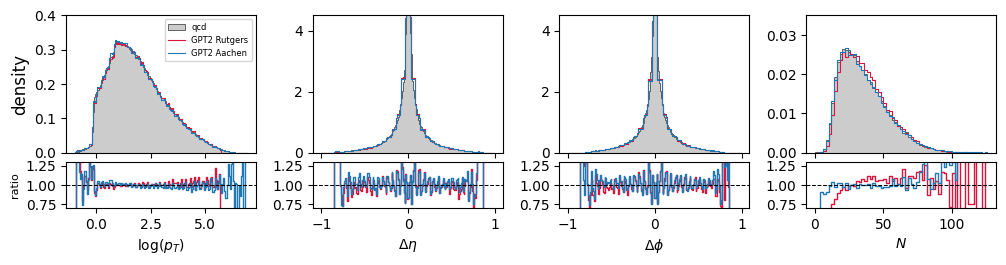

In [19]:
plot_kin_with_ratio(qcd_test_bins, qcd_gen_bins, qcd_aachen_bins, path='qcd_kin_plot.png', jet='qcd')

In [12]:
def jets_HL_feats(sample):
    pt = sample[..., 0]
    eta = sample[..., 1]
    phi = sample[..., 2]

    # px,py,pz:
    px = pt * np.cos(phi)
    py = pt * np.sin(phi)
    pz = pt * np.sinh(eta)
    E = pt * np.cosh(eta)

    jet_4mom = np.stack([px, py, pz, E], axis=-1)
    jet_4mom = jet_4mom.sum(axis=1)


    # Calculate the invariant mass of the jets
    jet_pt = np.sqrt(jet_4mom[..., 0]**2 + jet_4mom[..., 1]**2)
    jet_eta = np.arcsinh(jet_4mom[..., 2] / jet_pt)
    jet_phi = np.arctan2(jet_4mom[..., 1], jet_4mom[..., 0])
    jet_mass = np.sqrt(np.maximum(0, jet_4mom[..., 3]**2 - (jet_4mom[..., 0]**2 + jet_4mom[..., 1]**2 + jet_4mom[..., 2]**2)))

    return np.stack([jet_pt, jet_eta, jet_phi, jet_mass], axis=-1)



     

In [23]:
from utils import JetSubstructure

tops_HL_test = jets_HL_feats(tops_test_bins)
qcd_HL_test = jets_HL_feats(qcd_test_bins)
tops_HL_gen = jets_HL_feats(tops_gen_bins)
qcd_HL_gen = jets_HL_feats(qcd_gen_bins)
tops_HL_aachen = jets_HL_feats(tops_aachen_bins)
qcd_HL_aachen = jets_HL_feats(qcd_aachen_bins)

Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness


Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness


Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and pt-ordered Winner-Takes-All recombination
Calculating N-subjettiness


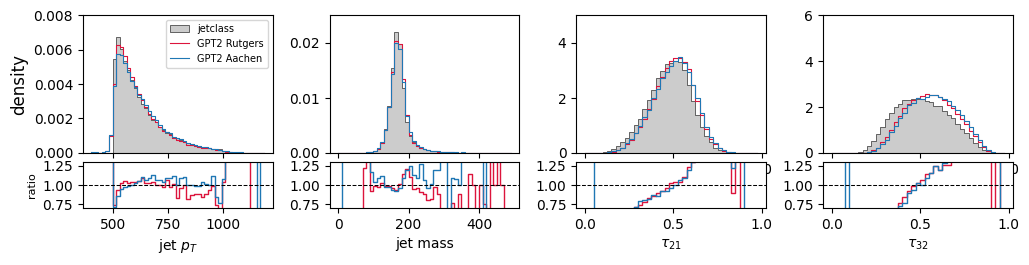

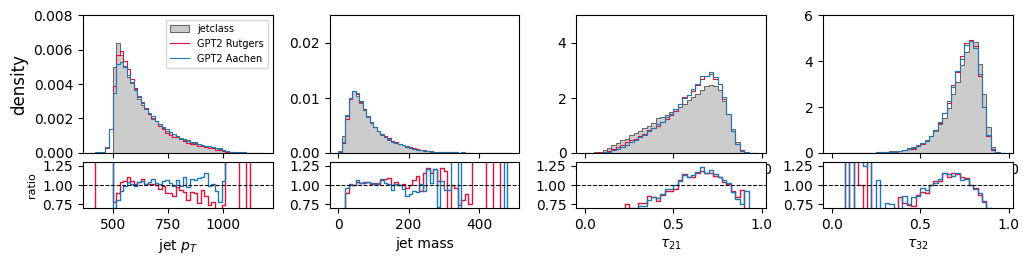

In [26]:
from utils import plot_hl_with_ratio
plot_hl_with_ratio(tops_test_bins, tops_gen_bins, tops_aachen_bins)
plot_hl_with_ratio(qcd_test_bins, qcd_gen_bins, qcd_aachen_bins)


In [ ]:

bins = [np.linspace(0.025, 0.4, 50), np.arange(0.75, 3, 0.06) , np.arange(0, 1, 0.025) , np.arange(0, 1, 0.025)]
plot_substructure_with_ratio(tops_sub, tops_gen_sub, tops_aachen_sub, bins, ylims=(17, 1.75, 4, 3),  jet='tops jetclass')

bins = [np.linspace(0, 0.4, 50), np.arange(0, 12, 0.25) , np.arange(0, 1, 0.025) , np.arange(0, 1, 0.025)]
plot_substructure_with_ratio(qcd_sub, qcd_gen_sub, qcd_aachen_sub, bins,  ylims=(20, 0.4, 3.5, 6),  jet='qcd jetclass')


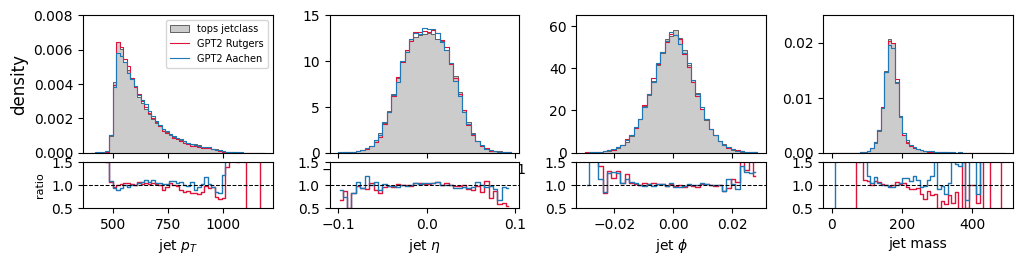

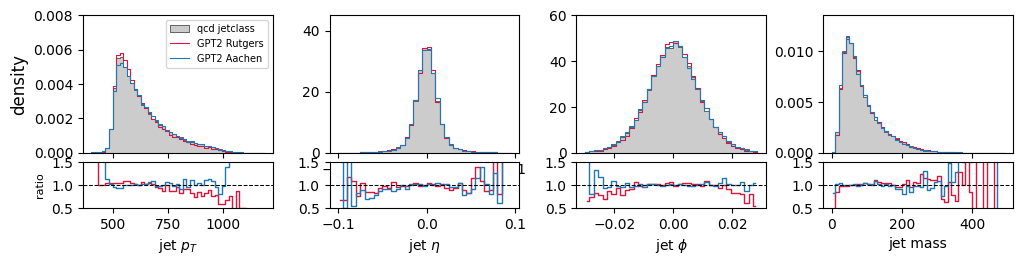

In [11]:
from utils import plot_hl_with_ratio, plot_substructure_with_ratio

bins0 = np.arange(400, 1200, 16)      # pT
bins1 = np.arange(-0.1, 0.1, 0.005) # eta
bins2 = np.arange(-0.03, 0.03, 0.0015)  # phi
bins3 = np.arange(0., 500, 10)    

bins = [bins0, bins1, bins2, bins3]

plot_hl_with_ratio(tops_HL_test, tops_HL_gen, tops_HL_aachen, bins, ylims=(0.008, 15, 65, 0.025), jet='tops jetclass')
# plot_hl_with_ratio(tops_HL_test, tops_HL_gen_, tops_HL_aachen, bins, ylims=(0.008, 15, 65, 0.025), jet='tops jetclass')

plot_hl_with_ratio(qcd_HL_test, qcd_HL_gen, qcd_HL_aachen, bins, ylims=(0.008, 45, 60, 0.0135), jet='qcd jetclass')
# plot_hl_with_ratio(qcd_HL_test, qcd_HL_gen_, qcd_HL_aachen, bins, ylims=(0.008, 45, 60, 0.0135), jet='qcd jetclass')


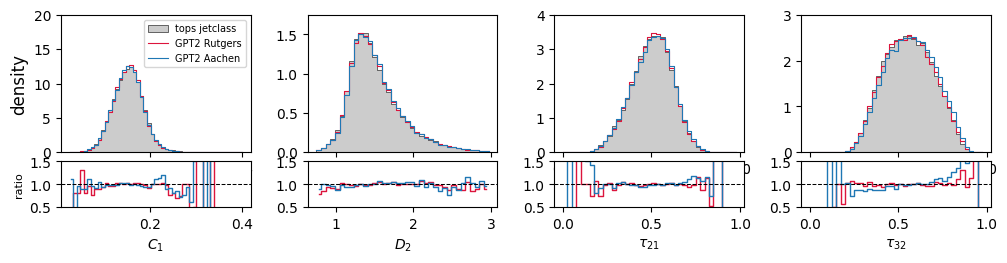

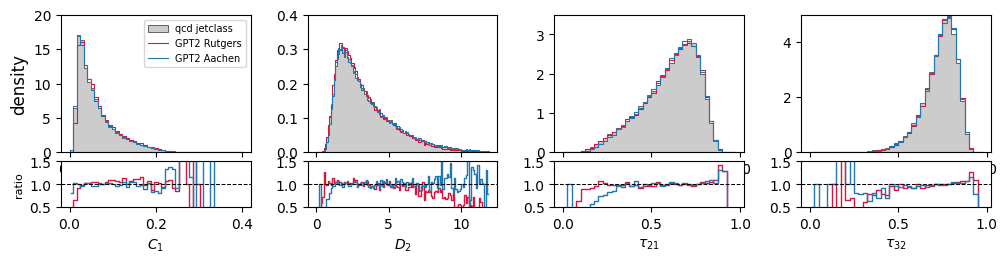

In [10]:
   

bins = [np.linspace(0.025, 0.4, 50), np.arange(0.75, 3, 0.06) , np.arange(0, 1, 0.025) , np.arange(0, 1, 0.025)]
plot_substructure_with_ratio(tops_sub, tops_gen_sub, tops_aachen_sub, bins, ylims=(17, 1.75, 4, 3),  jet='tops jetclass')

bins = [np.linspace(0, 0.4, 50), np.arange(0, 12, 0.25) , np.arange(0, 1, 0.025) , np.arange(0, 1, 0.025)]
plot_substructure_with_ratio(qcd_sub, qcd_gen_sub, qcd_aachen_sub, bins,  ylims=(20, 0.4, 3.5, 6),  jet='qcd jetclass')


### Check for ordering flips 

In [ ]:
k=0
flip_idx = []
for j, jet in enumerate(qcd_gen_bins):
    n = len(jet)
    for i, c in enumerate(jet):
        if i > 0:
            if jet[i,0] > jet[i-1, 0]:
                k+=1
                flip_idx.append(i)
                print(j, i)
                break


175 31
420 2
663 2
908 42
1092 1
1268 3
1400 23
1478 35
1505 21
1587 4
1591 27
1613 23
1651 43
1782 22
1852 20
2072 31
2164 34
2237 23
2453 14
2519 73
2801 6
2858 10
3047 4
3055 19
3069 1
3138 6
3257 13
3334 34
3381 10
3549 19
3647 6
3752 38
3894 4
3951 3
4015 1
4241 6
4453 25
4534 3
4535 7
4721 18
4858 39
4922 50
4955 32
4981 5
5019 3
5115 3
5525 12
5854 2
5900 9
5961 48
6095 33
6192 20
6246 4
6319 46
6411 33
6427 5
6485 33
6486 23
6873 7
6939 12
7126 46
7374 43
7418 14
7622 33
7632 2
7647 8
8036 25
8115 19
8390 49
8548 44
8559 1
8574 46
8788 29
8997 13
9069 14
9158 28
9481 23
9482 34
9593 44
9710 6
9791 5
9805 2
10018 22
10049 40
10082 11
10132 19
10280 2
10424 12
10685 2
10757 5
10769 65
10818 19
10946 11
11126 11
11172 25
11178 59
11305 29
11370 1
11618 22
11641 2
11669 3
11692 25
11799 49
11800 13
11965 59
12085 5
12185 44
12324 28
12456 16
12483 1
12712 22
12885 11
13032 28
13209 63
13321 4
13367 12
13398 3
13598 22
13615 29
13694 30
13840 5
14017 13
14386 26
14636 31
14760 9
149

freq flips:  0.00888


<Axes: ylabel='Density'>

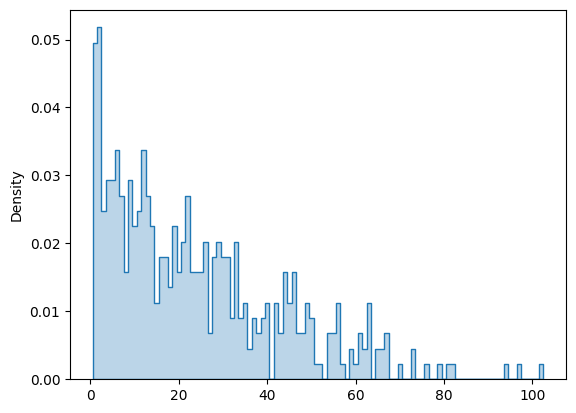

In [ ]:
print('freq flips: ', len(flip_idx) / N)
sns.histplot(flip_idx, discrete=True, fill=True, alpha=0.3, label='gpt2', element='step', stat='density',)

In [ ]:
k=0
flip_idx = []
for j, jet in enumerate(tops_gen_bins):
    n = len(jet)
    for i, c in enumerate(jet):
        if i > 0:
            if jet[i,0] > jet[i-1, 0]:
                k+=1
                flip_idx.append(i)
                print(j, i)
                break

42 50
152 2
239 40
343 29
431 25
450 4
515 39
638 19
670 3
766 46
797 33
820 44
828 53
884 18
969 33
1060 27
1196 37
1302 9
1435 12
1530 1
1623 35
1829 14
1958 40
1967 13
1974 58
1980 5
1998 13
2099 48
2153 54
2190 62
2252 7
2253 55
2326 15
2399 15
2546 4
2566 13
2600 65
2612 1
2639 30
2674 2
2692 9
2719 14
2776 14
2881 3
2891 6
2967 43
3021 12
3105 35
3148 65
3173 18
3204 37
3209 1
3215 13
3318 5
3406 7
3448 25
3625 23
3674 1
3724 4
3739 43
3794 11
3823 45
3836 11
3979 5
4007 2
4011 35
4025 71
4090 25
4149 20
4170 38
4328 24
4358 5
4439 52
4588 65
4612 45
4669 8
4680 7
4687 31
4695 13
4852 9
4868 22
4921 15
4932 25
4982 51
5068 4
5094 7
5381 75
5390 8
5493 35
5554 11
5555 1
5580 41
5612 21
5624 6
5653 40
5662 39
5761 31
5772 20
5778 2
5799 18
5883 13
5902 47
6356 15
6374 15
6449 45
6453 27
6568 23
6635 16
6663 6
6787 36
6942 4
6956 37
6964 2
6998 57
7090 44
7195 12
7210 44
7422 63
7463 3
7478 15
7543 23
7637 28
7777 3
7800 5
7809 9
7907 18
7909 33
7926 60
7941 3
7968 6
8078 1
8109 2
8

freq flips:  0.0163


<Axes: ylabel='Density'>

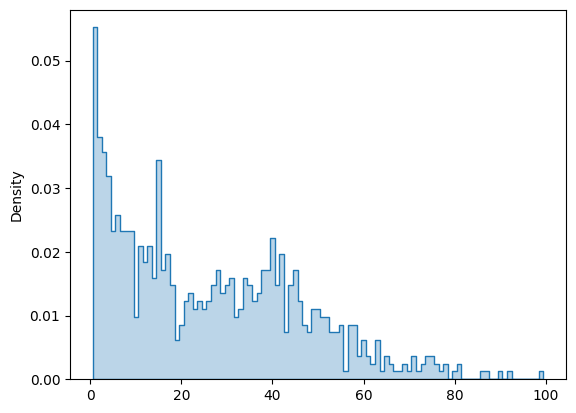

In [ ]:
print('freq flips: ', len(flip_idx) / N)
sns.histplot(flip_idx, discrete=True, fill=True, alpha=0.3, label='gpt2', element='step', stat='density',)

In [ ]:
# open yaml file

import yaml

def read_yaml_file(file_path):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print(f"Error reading YAML file: {e}")
            return None

bin_edges = read_yaml_file('bin_edges.yaml')


## Log-p computation

In [12]:
# tops_gpt2_ = JetGPT2Model.load_from_checkpoint(f"{path}/e66587b2c59b4773a97aa4afabd9b095/checkpoints/best.ckpt")
# tops_gpt2_.top_k = 5000 #tops_gpt2.start_token # remove top_k default cut
# tops_gpt2_.to("cuda:3")

# qcd_gpt2_ = JetGPT2Model.load_from_checkpoint(f"{path}/bfd0ed551863419a8a30e04b5a2fbae6/checkpoints/best.ckpt")
# qcd_gpt2_.top_k = 5000 #qcd_gpt2.start_token # remove top_k default cut
# qcd_gpt2_.to("cuda:2")

tops_gpt2 = JetGPT2Model.load_from_checkpoint(f"{path}/{sig_id}/checkpoints/best.ckpt")
tops_gpt2.top_k = 5000 #tops_gpt2.start_token # remove top_k default cut
tops_gpt2.to("cuda:1")

qcd_gpt2 = JetGPT2Model.load_from_checkpoint(f"{path}/{bkg_id}/checkpoints/best.ckpt")
qcd_gpt2.top_k = 5000 #qcd_gpt2.start_token # remove top_k default cut
qcd_gpt2.to("cuda:0")

Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint experiments/results/comet/tokenized-jets/17eab02a204343a3969183034847009d/checkpoints/best.ckpt`
Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint experiments/results/comet/tokenized-jets/301a89ea04ba46f59c2f39f34ff5f9b9/checkpoints/best.ckpt`


JetGPT2Model(
  (model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(39405, 256)
      (wpe): Embedding(201, 256)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-7): 8 x GPT2Block(
          (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2SdpaAttention(
            (c_attn): Conv1D(nf=768, nx=256)
            (c_proj): Conv1D(nf=256, nx=256)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=1024, nx=256)
            (c_proj): Conv1D(nf=256, nx=1024)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=256, out_features

### logp's on gen data

In [13]:
#...ROC curve

tops_logp_on_qcd = tops_gpt2.log_probs(qcd_gen_seq, batch_size=32, device=tops_gpt2.device)
tops_logp_on_tops = tops_gpt2.log_probs(tops_gen_seq, batch_size=32, device=tops_gpt2.device)
qcd_logp_on_qcd = qcd_gpt2.log_probs(qcd_gen_seq, batch_size=32, device=qcd_gpt2.device)
qcd_logp_on_tops = qcd_gpt2.log_probs(tops_gen_seq, batch_size=32, device=qcd_gpt2.device)

LLR_tops = tops_logp_on_tops - qcd_logp_on_tops    
LLR_qcd = tops_logp_on_qcd - qcd_logp_on_qcd   


# tops_logp_on_qcd_ = tops_gpt2_.log_probs(qcd_gen_seq_, batch_size=32, device=tops_gpt2_.device)
# tops_logp_on_tops_ = tops_gpt2_.log_probs(tops_gen_seq_, batch_size=32, device=tops_gpt2_.device)
# qcd_logp_on_qcd_ = qcd_gpt2_.log_probs(qcd_gen_seq_, batch_size=32, device=qcd_gpt2_.device)
# qcd_logp_on_tops_ = qcd_gpt2_.log_probs(tops_gen_seq_, batch_size=32, device=qcd_gpt2_.device)

# LLR_tops_ = tops_logp_on_tops_ - qcd_logp_on_tops_    
# LLR_qcd_ = tops_logp_on_qcd_ - qcd_logp_on_qcd_  

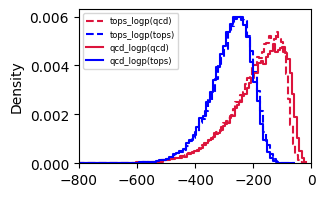

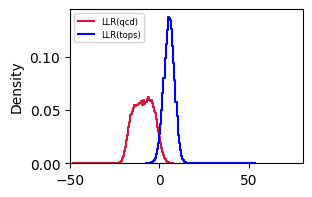

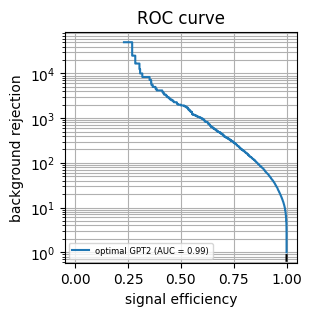

In [14]:
from utils  import ROC
import seaborn as sns

log = False
plt.figure(figsize=(3, 2))

sns.histplot(tops_logp_on_qcd, bins=100, ls='--', fill=False,label='tops_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(tops_logp_on_tops, bins=100, ls='--',fill=False, label='tops_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
sns.histplot(qcd_logp_on_qcd, bins=100, fill=False,  label='qcd_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(qcd_logp_on_tops, bins=100, fill=False,  label='qcd_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-800, 0)

plt.figure(figsize=(3, 2))

sns.histplot(LLR_qcd, bins=100, fill=False,label='LLR(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(LLR_tops, bins=100,fill=False, label='LLR(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-50, 80)

plt.figure(figsize=(3, 3))
ROC(LLR_qcd, LLR_tops, "optimal GPT2")
plt.grid(True,which='both')
plt.legend(fontsize=6, loc="lower left")


In [3]:
LLR_tops

NameError: name 'LLR_tops' is not defined

### logp's on test data

In [ ]:
tops_logp_on_qcd = tops_gpt2.log_probs(qcd_test_seq, batch_size=32, device=tops_gpt2.device)
tops_logp_on_tops = tops_gpt2.log_probs(tops_test_seq, batch_size=32, device=tops_gpt2.device)
qcd_logp_on_qcd = qcd_gpt2.log_probs(qcd_test_seq, batch_size=32, device=qcd_gpt2.device)
qcd_logp_on_tops = qcd_gpt2.log_probs(tops_test_seq, batch_size=32, device=qcd_gpt2.device)

/home/df630/SyntheticJets/utils.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1 / fpr, label=f"{label} (AUC = {roc_auc:.2f})")


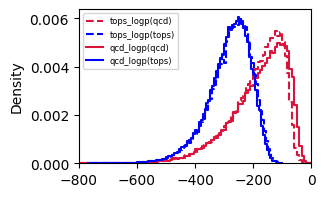

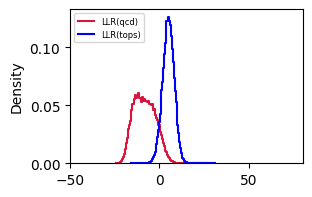

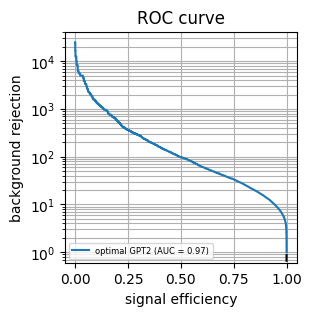

In [ ]:
from utils  import ROC
import seaborn as sns

log = False
plt.figure(figsize=(3, 2))

sns.histplot(tops_logp_on_qcd, bins=100, ls='--', fill=False,label='tops_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(tops_logp_on_tops, bins=100, ls='--',fill=False, label='tops_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
sns.histplot(qcd_logp_on_qcd, bins=100, fill=False,  label='qcd_logp(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(qcd_logp_on_tops, bins=100, fill=False,  label='qcd_logp(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-800, 0)

LLR_tops = tops_logp_on_tops - qcd_logp_on_tops    
LLR_qcd = tops_logp_on_qcd - qcd_logp_on_qcd   

plt.figure(figsize=(3, 2))

sns.histplot(LLR_qcd, bins=100, fill=False,label='LLR(qcd)', element='step', stat='density', color='crimson', log_scale=(False, log))
sns.histplot(LLR_tops, bins=100,fill=False, label='LLR(tops)', element='step', stat='density', color='blue', log_scale=(False, log))
plt.legend(fontsize=6, loc="upper left")
plt.xlim(-100, 0)


plt.figure(figsize=(3, 3))
ROC(LLR_qcd, LLR_tops, "optimal GPT2")
plt.grid(True,which='both')
plt.legend(fontsize=6, loc="lower left")

## Log-p per token scan 

In [1]:
import numpy as np

qcd_test_unsort = np.load('data/qcd_select_post_shuffled.npy')
qcd_idx = np.argsort(qcd_test_unsort[...,0])
qcd_test = np.array([qcd_test_unsort[j][i][::-1] for j, i in enumerate(qcd_idx)])

top_test_unsort = np.load('data/top_select_post_shuffled.npy')
top_idx = np.argsort(top_test_unsort[...,0])
top_test = np.array([top_test_unsort[j][i][::-1] for j, i in enumerate(top_idx)])

In [2]:
import pandas as pd
import h5py
import numpy as np
import torch
import os
from tqdm import tqdm


def log_factorial(N):
    sum_log = 0
    for n in  range(1, N + 1):
        sum_log += np.log(n)
    return sum_log


def get_tuples(table):
    part_pt = (table[...,0] ** 2 + table[...,1] ** 2) ** (1.0 / 2)
    part_p = (
        table["part_px"] ** 2 + table[...,1] ** 2 + table["part_pz"] ** 2
    ) ** (1.0 / 2)
    part_eta_dir = (
        0.5 * np.log((part_p + table["part_pz"]) / (part_p - table["part_pz"]))
        - table["jet_eta"]
    )
    part_phi_dir = (
        np.arctan2(table["part_py"], table["part_px"]) - table["jet_phi"] + np.pi
    ) % (2 * np.pi) - np.pi

    return part_pt, part_eta_dir, part_phi_dir


def to_numpy_array(tuple, n_max=200):
    constituents = np.zeros((len(tuple[0]), n_max, 3), dtype=np.float32)
    i = 0
    for pt, eta, phi in zip(*tuple):
        n_const = len(pt)
        if n_const > n_max:
            constituents[i, :, 0] = pt[:200]
            constituents[i, :, 1] = eta[:200]
            constituents[i, :, 2] = phi[:200]
        else:
            constituents[i, :n_const, 0] = pt
            constituents[i, :n_const, 1] = eta
            constituents[i, :n_const, 2] = phi
        i += 1
    return constituents


def to_dataframe(constituents):
    jets, consts, features = constituents.shape
    cols = [
        item
        for sublist in [f"PT_{i},Eta_{i},Phi_{i}".split(",") for i in range(200)]
        for item in sublist
    ]
    return pd.DataFrame(constituents.reshape((jets, consts * features)), columns=cols)


def discretize_data(
    data: str,
    lower_q: str,
    upper_q: str,
    nBins: list[int],
):
    
    def Get_features(data):
    
        const_pt=data[:,::3].copy()
        d_eta=data[:,1::3].copy()
        d_phi=data[:,2::3].copy()
    
        return const_pt,d_eta,d_phi
        
    def get_binning():
        '''
        # If QCD training as input, get the bins
        if "train" in str(input_file):
            pt_bins = np.linspace(
                np.quantile(np.log(const_pt[const_pt != 0]), lower_q),
                np.quantile(np.log(const_pt[const_pt != 0]), upper_q),
                nBins[0],
            )
            eta_bins = np.linspace(-0.8, 0.8, nBins[1])
            phi_bins = np.linspace(-0.8, 0.8, nBins[2])

            if not os.path.isdir("preprocessing_bins"):
                os.makedirs("preprocessing_bins")

            np.save(f"preprocessing_bins/pt_bins_{tag}", pt_bins)
            np.save(f"preprocessing_bins/eta_bins_{tag}", eta_bins)
            np.save(f"preprocessing_bins/phi_bins_{tag}", phi_bins)
            print("Created bins\n")
        # Else load the binning according to given tag
        '''

        pt_bins = np.load(f"data/preprocessing_bins/pt_bins_1Mfromeach_403030.npy")
        eta_bins = np.load(f"data/preprocessing_bins/eta_bins_1Mfromeach_403030.npy")
        phi_bins = np.load(f"data/preprocessing_bins/phi_bins_1Mfromeach_403030.npy")
        return pt_bins, eta_bins, phi_bins

    def discretize():
        const_pt_disc = np.digitize(np.log(const_pt), pt_bins).astype(np.int32)
        d_eta_disc = np.digitize(d_eta, eta_bins).astype(np.int32)
        d_phi_disc = np.digitize(d_phi, phi_bins).astype(np.int32)
        const_pt_disc[const_pt == 0] = -1
        d_eta_disc[const_pt == 0] = -1
        d_phi_disc[const_pt == 0] = -1
        return const_pt_disc, d_eta_disc, d_phi_disc

    def get_df(pt, eta, phi):
        stacked = np.stack([pt, eta, phi], -1)
        stacked = stacked.reshape((-1, 600))
        cols = [
            item
            for sublist in [f"PT_{i},Eta_{i},Phi_{i}".split(",") for i in range(200)]
            for item in sublist
        ]
        df = pd.DataFrame(stacked, columns=cols)
        return df

    print(f"INFO: Data shape: {data.shape}\n")

    const_pt, d_eta, d_phi = data[...,0], data[...,1], data[...,2]
    pt_bins, eta_bins, phi_bins = get_binning()
    const_pt_disc, d_eta_disc, d_phi_disc = discretize()

    print(f"INFO: pT bin range: {const_pt_disc[const_pt!=0].min()} {const_pt_disc.max()}")
    print(f"INFO: eta bin range: {d_eta_disc[const_pt!=0].min()} {d_eta_disc.max()}")
    print(f"INFO: phi bin range: {d_phi_disc[const_pt!=0].min()} {d_phi_disc.max()}\n")

    return np.stack([const_pt_disc, d_eta_disc, d_phi_disc], -1)


In [3]:
tops_tokens = discretize_data(data=top_test,
                              lower_q=0.001,
                              upper_q=1.0,
                              nBins=3,
                              )

qcd_tokens = discretize_data(data=qcd_test, 
                                lower_q=0.001,
                                upper_q=1.0,
                                nBins=3,
                                )       


INFO: Data shape: (10, 40, 3)



/tmp/ipykernel_42530/2027683928.py:102: RuntimeWarning: divide by zero encountered in log
  const_pt_disc = np.digitize(np.log(const_pt), pt_bins).astype(np.int32)


INFO: pT bin range: 4 34
INFO: eta bin range: 4 25
INFO: phi bin range: 3 29

INFO: Data shape: (10, 40, 3)

INFO: pT bin range: 0 33
INFO: eta bin range: 1 29
INFO: phi bin range: 4 26



In [101]:
res={}

In [166]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from models import JetGPT2Model
from datamodule_jetclass import JetSequence
import matplotlib.pyplot as plt
import seaborn as sns
from utils import make_continuous

bins = [41,31,31]
num_bins = np.prod(bins)  # e.g. 41*31*31

sample = 'qcd'
res[sample] = {'logpt':{}, 'eta':{}, 'phi':{}}

model = JetGPT2Model.load_from_checkpoint("/home/df630/SyntheticJets/experiments/results/comet/tokenized-jets/10eed87576d64e9e9bbb6f4a5322978d/checkpoints/best.ckpt")
model.top_k = 5000  
model.predict_type = 'gen'
model.to("cuda:1")

Lightning automatically upgraded your loaded checkpoint from v1.9.5 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint experiments/results/comet/tokenized-jets/10eed87576d64e9e9bbb6f4a5322978d/checkpoints/best.ckpt`


JetGPT2Model(
  (model): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(39404, 256)
      (wpe): Embedding(202, 256)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0-7): 8 x GPT2Block(
          (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2SdpaAttention(
            (c_attn): Conv1D(nf=768, nx=256)
            (c_proj): Conv1D(nf=256, nx=256)
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D(nf=1024, nx=256)
            (c_proj): Conv1D(nf=256, nx=1024)
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (lm_head): Linear(in_features=256, out_features

In [167]:
tops = JetSequence(data=tops_tokens, start_token=model.start_token, end_token=model.end_token, pad_token=model.pad_token, max_seq_length=40)
qcd = JetSequence(data=qcd_tokens, start_token=model.start_token, end_token=model.end_token, pad_token=model.pad_token, max_seq_length=40)

tops_seq = tops.map_to_sequence()
qcd_seq = qcd.map_to_sequence()

In [195]:
import torch

nth_jet = 9

seq_pt_prime = {}
seq_eta_prime = {}
seq_phi_prime = {}

logp_pt = {}
logp_eta = {}
logp_phi = {}

test = JetSequence()
seq = torch.tensor(qcd_seq[nth_jet])
const = top_test[nth_jet]

seq, const

(tensor([39401, 30270, 22551, 21621, 20660, 20660, 19699, 18835, 18738, 18803,
         17717, 16817, 16816, 16851, 15856, 15823, 14961, 15022, 13967, 13872,
         13935, 13072, 13067, 12972, 11950, 11983, 12044, 11980, 11020, 11052,
         10993, 10123,  9069,  8880,  9194,  9159,  8170,  8104,  8075,  8138,
          7207, 39402]),
 array([[ 7.08311157e+01,  6.18895292e-02, -5.93187809e-02],
        [ 6.57453079e+01,  8.08801651e-02, -4.56349850e-02],
        [ 6.18797150e+01,  6.66306615e-02, -3.80632877e-02],
        [ 5.97383194e+01, -1.53283060e-01, -2.05292702e-01],
        [ 4.71307716e+01, -1.44780457e-01, -2.12482929e-01],
        [ 3.90373077e+01,  8.57008100e-02, -4.01930809e-02],
        [ 3.69074936e+01, -1.33867145e-01, -2.07957268e-01],
        [ 3.11898575e+01,  7.84087181e-02, -9.71941948e-02],
        [ 2.52503853e+01,  7.53158331e-03,  3.06227446e-01],
        [ 2.36232662e+01,  5.41554689e-02,  3.25556993e-01],
        [ 2.08735065e+01, -4.59316969e-02,  2.150

In [196]:

nth_const = 1    #1 10 20 30
const = qcd_test[nth_jet][nth_const-1]

seq_pt = []
seq_eta = []
seq_phi = []

for i in range(0, bins[0]-1):
    c = seq.clone()
    c = torch.tensor(test.seq_to_bins_decoding(c))
    c[nth_const][0] = i
    mask = (seq != model.pad_token).unsqueeze(0).long()
    idx = int(mask.sum()) - 1
    _, i = torch.sort(c[1:idx][:, 0], dim=0, descending=True)
    c = torch.cat([c[:1], c[1:idx][i], c[idx:]])
    c = test.bins_to_seq_encoding(c.numpy())
    seq_pt.append(torch.tensor(c))

for i in range(0, bins[1]-1):
    y = seq.clone()
    c = torch.tensor(test.seq_to_bins_decoding(y)[nth_const])
    c[1]=i
    y[nth_const] = test.bins_to_seq_encoding(c.numpy())
    seq_eta.append(y)

for i in range(0, bins[2]-1):
    y = seq.clone()
    c = torch.tensor(test.seq_to_bins_decoding(y)[nth_const])
    c[2]=i
    y[nth_const] = test.bins_to_seq_encoding(c.numpy())
    seq_phi.append(y)
    
seq_pt_prime[nth_const] = torch.stack(seq_pt, dim=0)
seq_eta_prime[nth_const] = torch.stack(seq_eta, dim=0)
seq_phi_prime[nth_const] = torch.stack(seq_phi, dim=0)

model.to("cuda:1")

batch={}
batch['input_ids'] = seq_pt_prime[nth_const].clone().to("cuda:1")
batch['attention_mask'] = (seq_pt_prime[nth_const] != model.pad_token).unsqueeze(0).long().to("cuda:1")
logp_pt[nth_const] = model.compute_log_probs(batch, include_symmetry_terms=True)
res[sample]['logpt'][nth_jet] = np.stack([np.array([pt_bins[i] for i in range(0,40)]) , logp_pt[nth_const].cpu().numpy()], axis=1)

batch={}
batch['input_ids'] = seq_eta_prime[nth_const].clone().to("cuda:1")
batch['attention_mask'] = (seq_eta_prime[nth_const] != model.pad_token).unsqueeze(0).long().to("cuda:1")
logp_eta[nth_const] = model.compute_log_probs(batch, include_symmetry_terms=True)
res[sample]['eta'][nth_jet] = np.stack([np.array([eta_bins[i] for i in range(0,30)]) , logp_eta[nth_const].cpu().numpy()], axis=1)

batch={}
batch['input_ids'] = seq_phi_prime[nth_const].clone().to("cuda:1")
batch['attention_mask'] = (seq_phi_prime[nth_const] != model.pad_token).unsqueeze(0).long().to("cuda:1")
logp_phi[nth_const] = model.compute_log_probs(batch, include_symmetry_terms=True)
res[sample]['phi'][nth_jet] = np.stack([np.array([phi_bins[i] for i in range(0,30)]) , logp_phi[nth_const].cpu().numpy()], axis=1)


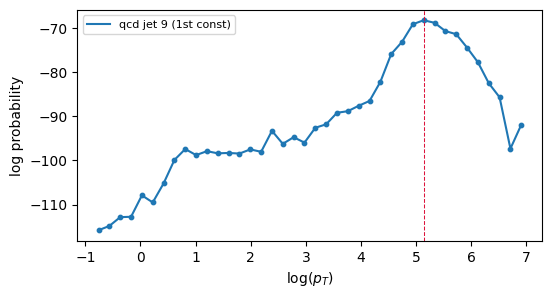

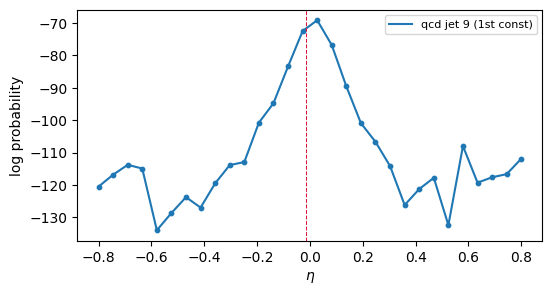

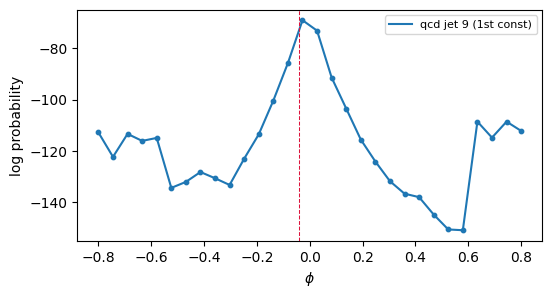

In [197]:
bin_dir = 'data'
pt_bins = np.load(f"{bin_dir}/preprocessing_bins/pt_bins_1Mfromeach_403030.npy")
eta_bins = np.load(f"{bin_dir}/preprocessing_bins/eta_bins_1Mfromeach_403030.npy")
phi_bins = np.load(f"{bin_dir}/preprocessing_bins/phi_bins_1Mfromeach_403030.npy")

# remove line from plot
plt.figure(figsize=(6, 3))
plt.plot(res[sample]['logpt'][nth_jet][...,0], res[sample]['logpt'][nth_jet][...,1], label=f'{sample} jet {nth_jet} (1st const)')
plt.axvline(x=np.log(const[0]), color='crimson', linestyle='--', lw=0.75)
plt.scatter(res[sample]['logpt'][nth_jet][...,0], res[sample]['logpt'][nth_jet][...,1], s=10)
plt.xlabel(r'$\log(p_T)$')
plt.ylabel('log probability')
plt.legend(fontsize=8)
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(res[sample]['eta'][nth_jet][...,0], res[sample]['eta'][nth_jet][...,1], label=f'{sample} jet {nth_jet} (1st const)')
plt.axvline(x=const[1], color='crimson', linestyle='--', lw=0.75)
plt.scatter(res[sample]['eta'][nth_jet][...,0], res[sample]['eta'][nth_jet][...,1], s=10)
plt.xlabel(r'$\eta$')
plt.ylabel('log probability')
plt.legend(fontsize=8)
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(res[sample]['phi'][nth_jet][...,0], res[sample]['phi'][nth_jet][...,1], label=f'{sample} jet {nth_jet} (1st const)')
plt.axvline(x=const[2], color='crimson', linestyle='--', lw=0.75)
plt.scatter(res[sample]['phi'][nth_jet][...,0], res[sample]['phi'][nth_jet][...,1], s=10)

plt.xlabel(r'$\phi$')
plt.ylabel('log probability')
plt.legend(fontsize=8)
plt.show()

In [199]:
res['qcd']

{'logpt': {0: array([[-7.60297119e-01, -7.32657089e+01],
         [-5.63718865e-01, -7.26274490e+01],
         [-3.67140612e-01, -7.16084366e+01],
         [-1.70562358e-01, -6.72849045e+01],
         [ 2.60158954e-02, -6.39757309e+01],
         [ 2.22594149e-01, -6.35893936e+01],
         [ 4.19172402e-01, -6.54001770e+01],
         [ 6.15750656e-01, -6.50060730e+01],
         [ 8.12328909e-01, -6.44589844e+01],
         [ 1.00890716e+00, -6.28097000e+01],
         [ 1.20548542e+00, -6.71804504e+01],
         [ 1.40206367e+00, -6.97849655e+01],
         [ 1.59864192e+00, -6.62522354e+01],
         [ 1.79522018e+00, -6.41669693e+01],
         [ 1.99179843e+00, -6.52314377e+01],
         [ 2.18837668e+00, -6.51408920e+01],
         [ 2.38495494e+00, -6.31991653e+01],
         [ 2.58153319e+00, -6.33828278e+01],
         [ 2.77811144e+00, -6.19001083e+01],
         [ 2.97468970e+00, -6.20901108e+01],
         [ 3.17126795e+00, -5.90386810e+01],
         [ 3.36784621e+00, -5.94196472e+01]

In [200]:
import h5py
import numpy as np

def save_nested_dict_to_h5(dic, filename):
    def recursively_save_dict_contents(h5file, path, dic):
        for key, item in dic.items():
            key = str(key)  # h5py requires string keys
            if isinstance(item, dict):
                group = h5file.require_group(f"{path}/{key}")
                recursively_save_dict_contents(h5file, f"{path}/{key}", item)
            else:
                h5file[f"{path}/{key}"] = item

    with h5py.File(filename, 'w') as h5file:
        recursively_save_dict_contents(h5file, '/', dic)

save_nested_dict_to_h5(res, 'log_probs.h5')


In [201]:
def load_nested_dict_from_h5(filename):
    def recursively_load_dict_contents(h5file, path):
        out = {}
        for key in h5file[path]:
            subpath = f"{path}/{key}"
            if isinstance(h5file[subpath], h5py.Group):
                out[key] = recursively_load_dict_contents(h5file, subpath)
            else:
                out[key] = h5file[subpath][()]
        return out

    with h5py.File(filename, 'r') as h5file:
        return recursively_load_dict_contents(h5file, '/')

#usage
loaded_dic = load_nested_dict_from_h5('log_probs.h5')



In [202]:
loaded_dic

{'qcd': {'eta': {'0': array([[-8.00000000e-01, -8.62703171e+01],
          [-7.44827586e-01, -8.04257584e+01],
          [-6.89655172e-01, -7.35107574e+01],
          [-6.34482759e-01, -7.80240555e+01],
          [-5.79310345e-01, -7.70970993e+01],
          [-5.24137931e-01, -8.10032349e+01],
          [-4.68965517e-01, -9.91098404e+01],
          [-4.13793103e-01, -9.28039322e+01],
          [-3.58620690e-01, -8.84797592e+01],
          [-3.03448276e-01, -8.63114548e+01],
          [-2.48275862e-01, -8.36307831e+01],
          [-1.93103448e-01, -7.86730881e+01],
          [-1.37931034e-01, -7.43320847e+01],
          [-8.27586207e-02, -6.26864090e+01],
          [-2.75862069e-02, -4.70867310e+01],
          [ 2.75862069e-02, -3.76455765e+01],
          [ 8.27586207e-02, -4.81103592e+01],
          [ 1.37931034e-01, -6.84861298e+01],
          [ 1.93103448e-01, -7.92829056e+01],
          [ 2.48275862e-01, -8.65724487e+01],
          [ 3.03448276e-01, -9.20746765e+01],
          [ 3.5

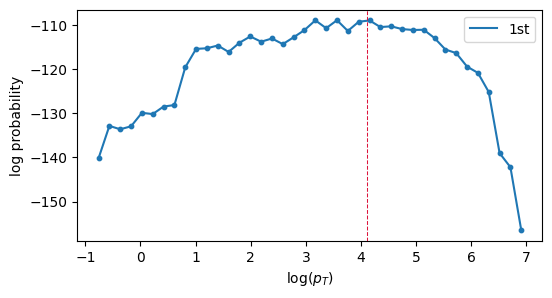

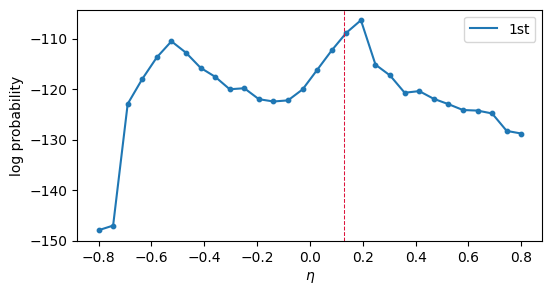

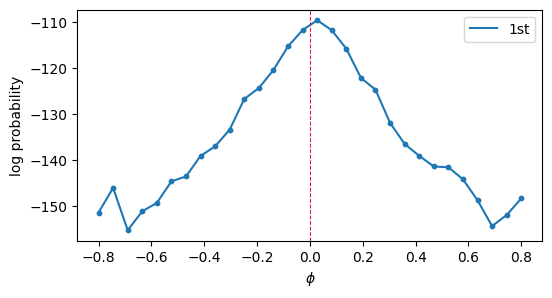

In [11]:
bin_dir = 'data'
pt_bins = np.load(f"{bin_dir}/preprocessing_bins/pt_bins_1Mfromeach_403030.npy")
eta_bins = np.load(f"{bin_dir}/preprocessing_bins/eta_bins_1Mfromeach_403030.npy")
phi_bins = np.load(f"{bin_dir}/preprocessing_bins/phi_bins_1Mfromeach_403030.npy")

# remove line from plot
plt.figure(figsize=(6, 3))
plt.plot([pt_bins[i] for i in range(0,40)], logp_pt[1].cpu().numpy(), label='1st')
plt.axvline(x=np.log(const[0]), color='crimson', linestyle='--', lw=0.75)

# plt.plot([pt_bins[i] for i in range(0,40)], logp_pt[2].cpu().numpy(), label='2nd')
# plt.plot([pt_bins[i] for i in range(0,40)], logp_pt[5].cpu().numpy(), label='5th')
# plt.plot([pt_bins[i] for i in range(0,40)], logp_pt[10].cpu().numpy(), label='30th')
plt.scatter([pt_bins[i] for i in range(0,40)], logp_pt[1].cpu().numpy(), s=10)
# plt.scatter([pt_bins[i] for i in range(0,40)], logp_pt[2].cpu().numpy(), s=10)
# plt.scatter([pt_bins[i] for i in range(0,40)], logp_pt[5].cpu().numpy(), s=10)
# plt.scatter([pt_bins[i] for i in range(0,40)], logp_pt[10].cpu().numpy(), s=10)
plt.xlabel(r'$\log(p_T)$')
plt.ylabel('log probability')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot([eta_bins[i] for i in range(0,30)], logp_eta[1].cpu().numpy(), label='1st')
plt.axvline(x=const[1], color='crimson', linestyle='--', lw=0.75)

# plt.plot([eta_bins[i] for i in range(0,30)], logp_eta[2].cpu().numpy(), label='2nd')
# plt.plot([eta_bins[i] for i in range(0,30)], logp_eta[5].cpu().numpy(), label='5th')
# plt.plot([eta_bins[i] for i in range(0,30)], logp_eta[10].cpu().numpy(), label='10th')
plt.scatter([eta_bins[i] for i in range(0,30)], logp_eta[1].cpu().numpy(), s=10)
# plt.scatter([eta_bins[i] for i in range(0,30)], logp_eta[2].cpu().numpy(), s=10)
# plt.scatter([eta_bins[i] for i in range(0,30)], logp_eta[5].cpu().numpy(), s=10)
# plt.scatter([eta_bins[i] for i in range(0,30)], logp_eta[10].cpu().numpy(), s=10)
plt.xlabel(r'$\eta$')
plt.ylabel('log probability')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot([phi_bins[i] for i in range(0,30)], logp_phi[1].cpu().numpy(), label='1st')
plt.axvline(x=const[2], color='crimson', linestyle='--', lw=0.75)

# plt.plot([phi_bins[i] for i in range(0,30)], logp_phi[2].cpu().numpy(), label='2nd')
# plt.plot([phi_bins[i] for i in range(0,30)], logp_phi[5].cpu().numpy(), label='5th')
# plt.plot([phi_bins[i] for i in range(0,30)], logp_phi[10].cpu().numpy(), label='10th')
plt.scatter([phi_bins[i] for i in range(0,30)], logp_phi[1].cpu().numpy(), s=10)
# plt.scatter([phi_bins[i] for i in range(0,30)], logp_phi[2].cpu().numpy(), s=10)
# plt.scatter([phi_bins[i] for i in range(0,30)], logp_phi[5].cpu().numpy(), s=10)
# plt.scatter([phi_bins[i] for i in range(0,30)], logp_phi[10].cpu().numpy(), s=10)
plt.xlabel(r'$\phi$')
plt.ylabel('log probability')
plt.legend()
plt.show()

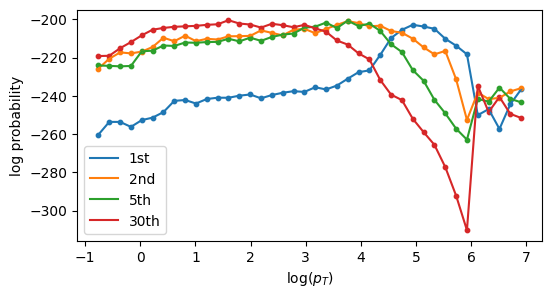

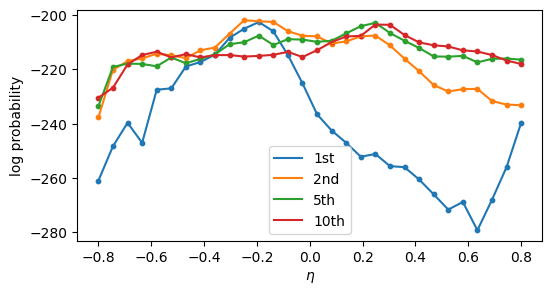

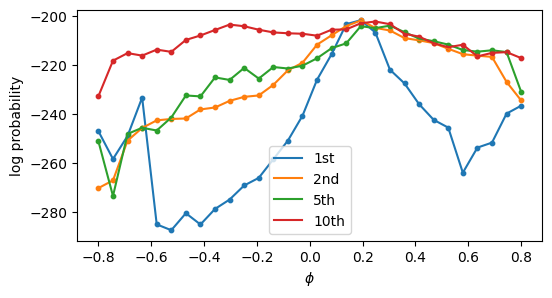

In [25]:
bin_dir = 'data'
pt_bins = np.load(f"{bin_dir}/preprocessing_bins/pt_bins_1Mfromeach_403030.npy")
eta_bins = np.load(f"{bin_dir}/preprocessing_bins/eta_bins_1Mfromeach_403030.npy")
phi_bins = np.load(f"{bin_dir}/preprocessing_bins/phi_bins_1Mfromeach_403030.npy")

# remove line from plot
plt.figure(figsize=(6, 3))
plt.plot([pt_bins[i] for i in range(0,40)], logp_pt[1].cpu().numpy(), label='1st')
plt.plot([pt_bins[i] for i in range(0,40)], logp_pt[2].cpu().numpy(), label='2nd')
plt.plot([pt_bins[i] for i in range(0,40)], logp_pt[5].cpu().numpy(), label='5th')
plt.plot([pt_bins[i] for i in range(0,40)], logp_pt[10].cpu().numpy(), label='30th')
plt.scatter([pt_bins[i] for i in range(0,40)], logp_pt[1].cpu().numpy(), s=10)
plt.scatter([pt_bins[i] for i in range(0,40)], logp_pt[2].cpu().numpy(), s=10)
plt.scatter([pt_bins[i] for i in range(0,40)], logp_pt[5].cpu().numpy(), s=10)
plt.scatter([pt_bins[i] for i in range(0,40)], logp_pt[10].cpu().numpy(), s=10)
plt.xlabel(r'$\log(p_T)$')
plt.ylabel('log probability')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot([eta_bins[i] for i in range(0,30)], logp_eta[1].cpu().numpy(), label='1st')
plt.plot([eta_bins[i] for i in range(0,30)], logp_eta[2].cpu().numpy(), label='2nd')
plt.plot([eta_bins[i] for i in range(0,30)], logp_eta[5].cpu().numpy(), label='5th')
plt.plot([eta_bins[i] for i in range(0,30)], logp_eta[10].cpu().numpy(), label='10th')
plt.scatter([eta_bins[i] for i in range(0,30)], logp_eta[1].cpu().numpy(), s=10)
plt.scatter([eta_bins[i] for i in range(0,30)], logp_eta[2].cpu().numpy(), s=10)
plt.scatter([eta_bins[i] for i in range(0,30)], logp_eta[5].cpu().numpy(), s=10)
plt.scatter([eta_bins[i] for i in range(0,30)], logp_eta[10].cpu().numpy(), s=10)
plt.xlabel(r'$\eta$')
plt.ylabel('log probability')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.plot([phi_bins[i] for i in range(0,30)], logp_phi[1].cpu().numpy(), label='1st')
plt.plot([phi_bins[i] for i in range(0,30)], logp_phi[2].cpu().numpy(), label='2nd')
plt.plot([phi_bins[i] for i in range(0,30)], logp_phi[5].cpu().numpy(), label='5th')
plt.plot([phi_bins[i] for i in range(0,30)], logp_phi[10].cpu().numpy(), label='10th')
plt.scatter([phi_bins[i] for i in range(0,30)], logp_phi[1].cpu().numpy(), s=10)
plt.scatter([phi_bins[i] for i in range(0,30)], logp_phi[2].cpu().numpy(), s=10)
plt.scatter([phi_bins[i] for i in range(0,30)], logp_phi[5].cpu().numpy(), s=10)
plt.scatter([phi_bins[i] for i in range(0,30)], logp_phi[10].cpu().numpy(), s=10)
plt.xlabel(r'$\phi$')
plt.ylabel('log probability')
plt.legend()
plt.show()


In [ ]:


def make_continuous(jets, bin_dir='/pscratch/sd/d/dfarough/JetClass', make_continuos=False):

    """
    log(pt) bins:  
    
    [-0.76029712 -0.56371887 -0.36714061 -0.17056236  0.0260159   0.22259415
    0.4191724   0.61575066  0.81232891  1.00890716  1.20548542  1.40206367
    1.59864192  1.79522018  1.99179843  2.18837668  2.38495494  2.58153319
    2.77811144  2.9746897   3.17126795  3.36784621  3.56442446  3.76100271
    3.95758097  4.15415922  4.35073747  4.54731573  4.74389398  4.94047223
    5.13705049  5.33362874  5.53020699  5.72678525  5.9233635   6.11994175
    6.31652001  6.51309826  6.70967651  6.90625477]

    eta bins:  
    
    [-0.8        -0.74482759 -0.68965517 -0.63448276 -0.57931034 -0.52413793
    -0.46896552 -0.4137931  -0.35862069 -0.30344828 -0.24827586 -0.19310345
    -0.13793103 -0.08275862 -0.02758621  0.02758621  0.08275862  0.13793103
    0.19310345  0.24827586  0.30344828  0.35862069  0.4137931   0.46896552
    0.52413793  0.57931034  0.63448276  0.68965517  0.74482759  0.8       ]

    phi bins:  
    
    [-0.8        -0.74482759 -0.68965517 -0.63448276 -0.57931034 -0.52413793
    -0.46896552 -0.4137931  -0.35862069 -0.30344828 -0.24827586 -0.19310345
    -0.13793103 -0.08275862 -0.02758621  0.02758621  0.08275862  0.13793103
    0.19310345  0.24827586  0.30344828  0.35862069  0.4137931   0.46896552
    0.52413793  0.57931034  0.63448276  0.68965517  0.74482759  0.8       ]

    """


    pt_bins = np.load(f"{bin_dir}/preprocessing_bins/pt_bins_1Mfromeach_403030.npy")
    eta_bins = np.load(f"{bin_dir}/preprocessing_bins/eta_bins_1Mfromeach_403030.npy")
    phi_bins = np.load(f"{bin_dir}/preprocessing_bins/phi_bins_1Mfromeach_403030.npy")

    print(len(pt_bins), len(eta_bins), len(phi_bins))

    pt_disc = jets[:, :, 0]
    eta_disc = jets[:, :, 1]
    phi_disc = jets[:, :, 2]

    mask = pt_disc < 0

    d_pt = np.abs(pt_bins[1] - pt_bins[0])
    d_eta = np.abs(eta_bins[1] - eta_bins[0])
    d_phi = np.abs(phi_bins[1] - phi_bins[0])

    if make_continuos:
        pt_con = (pt_disc - np.random.uniform(0.0, 1.0, size=pt_disc.shape)) * (
            pt_bins[1] - pt_bins[0]
        ) + pt_bins[0]

        eta_con = (eta_disc - np.random.uniform(0.0, 1.0, size=eta_disc.shape)) * (
            eta_bins[1] - eta_bins[0]
        ) + eta_bins[0]
        
        phi_con = (phi_disc - np.random.uniform(0.0, 1.0, size=phi_disc.shape)) * (
            phi_bins[1] - phi_bins[0]
        ) + phi_bins[0]
    
    else:
        pt_con = pt_bins[pt_disc] + 0.5 * d_pt
        eta_con = eta_bins[eta_disc] + 0.5 * d_eta
        phi_con = phi_bins[phi_disc] + 0.5 * d_phi

    continues_jets = np.stack((np.exp(pt_con), eta_con, phi_con), -1)
    continues_jets[mask] = 0

    return torch.tensor(continues_jets)

_tops_seq = torch.tensor(tops_seq, dtype=torch.int64)
data_tokens = torch.where(_tops_seq >= 39401, -1 * torch.ones_like(_tops_seq), _tops_seq)
data_binned = make_continuous(tops.seq_to_bins_decoding(data_tokens)[:, 1:-1], '/home/df630/SyntheticJets/data') # rm start token

data_binned[3]